In [11]:
import numpy as nps
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.__version__
import pandas as pd
pd.__version__

import seaborn as sns

In [15]:
import sklearn
sklearn.__version__

'1.7.1'

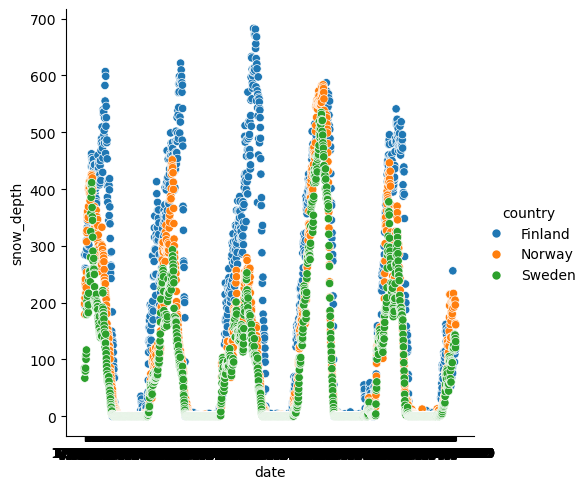

In [13]:
df = pd.read_csv('data/nordics_weather.csv', parse_dates=True)
sns.relplot(df, x='date', y='snow_depth',hue='country')

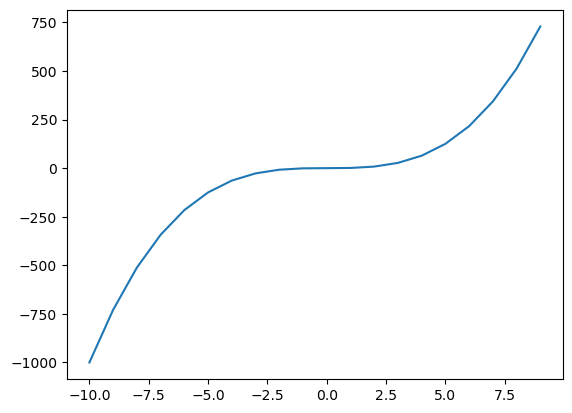

In [2]:
x = np.arange(-10,10,1)
y = x**3
plt.plot(x,y)